In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
BATCH_SIZE = 16
IMG_SIZE = (224, 224)
MAX_EPOCHS = 15
DATA_DIR = "/Users/omgoswami/Downloads/split/Cervical and Kidney Cancer/cervical"

TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "valid")
TEST_DIR = os.path.join(DATA_DIR, "test")
class_names = ["cervix_dyk","cervix_koc","cervix_mep","cervix_pab","cervix_sfi"]
class_details = ["cervix_dyk","cervix_koc","cervix_mep","cervix_pab","cervix_sfi"]

datagen = ImageDataGenerator(preprocessing_function=lambda img: img,
                             horizontal_flip=True)

train_gen = datagen.flow_from_directory(TRAIN_DIR,
                                        target_size=IMG_SIZE,
                                        class_mode='categorical',
                                        classes=class_names,
                                        batch_size=BATCH_SIZE)

valid_gen = datagen.flow_from_directory(VAL_DIR,
                                        target_size=IMG_SIZE,
                                        class_mode='categorical',
                                        classes=class_names,
                                        batch_size=BATCH_SIZE)

test_gen = datagen.flow_from_directory(TEST_DIR,
                                        target_size=IMG_SIZE,
                                        class_mode='categorical',
                                        classes=class_names,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)

Found 17500 images belonging to 5 classes.
Found 3750 images belonging to 5 classes.
Found 3750 images belonging to 5 classes.


In [3]:
def print_image_count(dataset, dataset_name):
    num_images = len(dataset) * BATCH_SIZE
    print(f"Number of images in {dataset_name} dataset: {num_images}")

print_image_count(train_gen, "train")
print_image_count(valid_gen, "validation")
print_image_count(test_gen, "test")

Number of images in train dataset: 17504
Number of images in validation dataset: 3760
Number of images in test dataset: 3760


In [4]:
pretrained_efficientnet_base = tf.keras.applications.efficientnet.EfficientNetB5(
    include_top=False, weights="imagenet", input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), pooling="max"
)
pretrained_efficientnet_base.trainable = False

efficentNet_model = tf.keras.Sequential([
    pretrained_efficientnet_base,
    layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(l=0.016),
                 activity_regularizer=tf.keras.regularizers.l1(0.006),
                 bias_regularizer=tf.keras.regularizers.l1(0.006), activation='relu'),
    layers.Dropout(rate=0.45, seed=123),
    layers.Dense(len(class_names), activation='softmax')
])

efficentNet_model.compile(tf.keras.optimizers.Adamax(learning_rate=0.001),
                          loss='categorical_crossentropy', metrics=['accuracy'])

efficentNet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 2048)             28513527  
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 29,047,548
Trainable params: 529,925
Non-trainable params: 28,517,623
______________________________________

In [5]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True,
                               mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              min_lr=0.001,
                              mode='min')

# Train the model
history = efficentNet_model.fit(x=train_gen,
                                epochs=MAX_EPOCHS,
                                verbose=1,
                                validation_data=valid_gen,
                                validation_steps=None,
                                shuffle=False,
                                batch_size=BATCH_SIZE,
                                callbacks=[early_stopping, reduce_lr])

Epoch 1/15


2024-03-02 18:11:35.901095: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1094/1094 [==============================] - 612s 553ms/step - loss: 5.5767 - accuracy: 0.7638 - val_loss: 2.7601 - val_accuracy: 0.8952 - lr: 0.0010
Epoch 2/15
1094/1094 [==============================] - 682s 623ms/step - loss: 2.0545 - accuracy: 0.8397 - val_loss: 1.4951 - val_accuracy: 0.9045 - lr: 0.0010
Epoch 3/15
1094/1094 [==============================] - 676s 618ms/step - loss: 1.5061 - accuracy: 0.8437 - val_loss: 1.3594 - val_accuracy: 0.9109 - lr: 0.0010
Epoch 4/15
1094/1094 [==============================] - 672s 614ms/step - loss: 1.4682 - accuracy: 0.8499 - val_loss: 1.3834 - val_accuracy: 0.9075 - lr: 0.0010
Epoch 5/15
1094/1094 [==============================] - 688s 629ms/step - loss: 1.4789 - accuracy: 0.8522 - val_loss: 1.3976 - val_accuracy: 0.9147 - lr: 0.0010
Epoch 6/15
1094/1094 [==============================] - 676s 618ms/step - loss: 1.5365 - accuracy: 0.8497 - val_loss: 1.4718 - val_accuracy: 0.9048 - lr: 0.0010
Epoch 7/15
1094/1094 [=======================

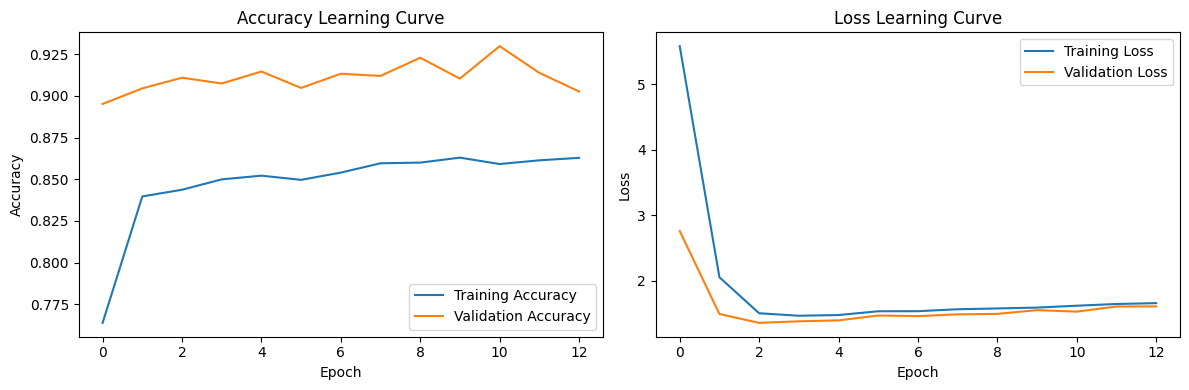

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
from sklearn.metrics import confusion_matrix, classification_report

test_loss, test_accuracy = efficentNet_model.evaluate(test_gen)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

235/235 [==============================] - 111s 471ms/step - loss: 1.3527 - accuracy: 0.9160
Test Accuracy: 91.60%


In [8]:
predictions = efficentNet_model.predict(test_gen)
true_labels = test_gen.classes
predicted_labels = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(true_labels, predicted_labels)
class_report = classification_report(true_labels, predicted_labels, target_names=class_names)

print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)

235/235 [==============================] - 114s 467ms/step
Confusion Matrix:
[[687  41  12   6   4]
 [ 59 619  30   1  41]
 [ 30  28 682   4   6]
 [  4   3   1 741   1]
 [  3  21  15   1 710]]

Classification Report:
              precision    recall  f1-score   support

  cervix_dyk       0.88      0.92      0.90       750
  cervix_koc       0.87      0.83      0.85       750
  cervix_mep       0.92      0.91      0.92       750
  cervix_pab       0.98      0.99      0.99       750
  cervix_sfi       0.93      0.95      0.94       750

    accuracy                           0.92      3750
   macro avg       0.92      0.92      0.92      3750
weighted avg       0.92      0.92      0.92      3750



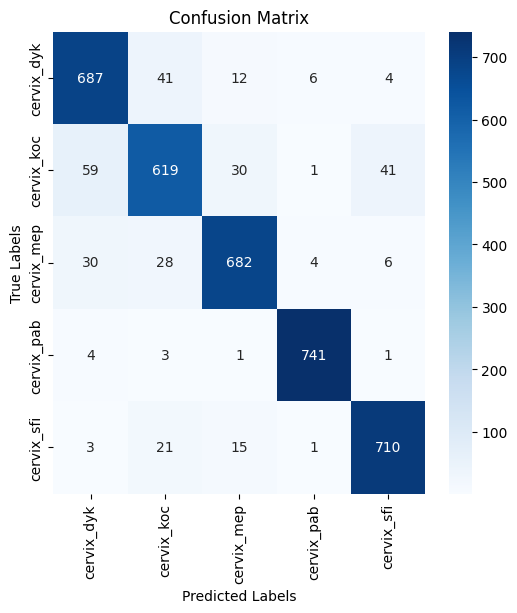

In [9]:
import seaborn as sns
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

plot_confusion_matrix(conf_matrix, class_names)

235/235 [==============================] - 102s 435ms/step


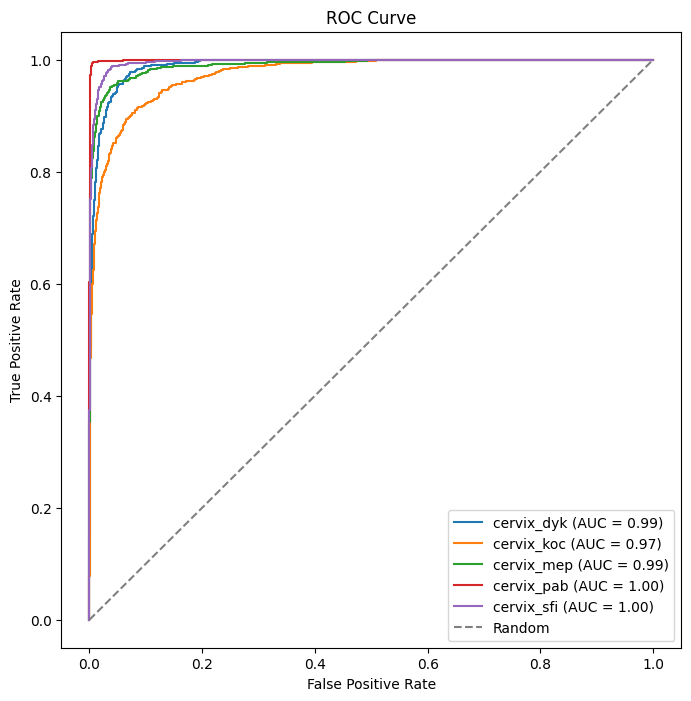

In [10]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_scores, class_labels):
    plt.figure(figsize=(8, 8))
    for i in range(len(class_labels)):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

y_prob = efficentNet_model.predict(test_gen)
y_true = test_gen.classes

y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=len(class_names))

plot_roc_curve(y_true_one_hot, y_prob, class_names)